In [ ]:
import json
import pandas as pd
from collections import Counter, defaultdict
from datetime import datetime, date, timedelta
from urllib.parse import urlparse

def load_history(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    browser_history = data.get('Browser History', [])
    # Filter out entries with YouTube URLs
    filtered_history = [entry for entry in browser_history if 'youtube.com' not in entry.get('url', '') and 'youtu.be' not in entry.get('url', '')]
    return filtered_history
    # return data.get('Browser History', [])

### DEFINE YOUR DOMAIN TYPE MAP HERE 
domain_type_map = {
    'doc.google.com':   'class_work',
    'drive.google.com': 'class_work',
    'canvas.virginia.edu': 'class_work',
    'tomflectcher.github.io': 'class_work',
    'outlook.office.com': 'reserach(explore)',
    'outlook.office.com': 'reserach(dev)',
    'outlook.office.com': 'class_work',
    'lucid.app': 'research(dev)',
    'openreview.net': 'research(dev)',
    'huggingface.co': 'research(dev)',
    'ood.hpc.virginia.edu': 'research(dev)',
    'overleaf.com': 'research(dev)',
    'anonymous.4open.science': 'research(dev)',
    'colab.research.google.com': 'research(dev)',
    'wordcounts.com': 'research(dev)',
    'www.google.com':    'research(explore)',
    'web.stanford.edu': 'research(explore)',
    'ieeexplore.ieee.org': 'research(explore)',
    'github.com':     'research(explore)',
    'arxiv.org':     'research(explore)',
    'dl.acm.org':   'research(explore)',
    'pmc.ncbi.nlm.nih.gov': 'research(explore)',
    'www.cs.emory.edu': 'research(explore)',
    'proceedings.neurips.cc': 'research(explore)',
    'aclanthology.org': 'research(explore)',
    'ijcai.org': 'research(explore)',
}


def domain_from_url(url):
    netloc = urlparse(url).netloc
    return netloc.split(':')[0].lower()

def site_type_from_domain(domain):
    # fallback to 'other' if domain not in your map
    return domain_type_map.get(domain, 'other')

def most_common_site_types_daily(history, start_date, end_date):
    """
    Returns a dict mapping 'YYYY-MM-DD' -> Counter(site_type -> visits on that day).
    """
    daily_type_counts = defaultdict(Counter)
    for entry in history:
        ts  = entry.get('time_usec')
        url = entry.get('url')
        if ts and url:
            dt = datetime.utcfromtimestamp(ts / 1e6)
            day = dt.date()
            if start_date <= day <= end_date:
                domain = domain_from_url(url)
                site_type = site_type_from_domain(domain)
                daily_type_counts[day.isoformat()][site_type] += 1

    return daily_type_counts



def load_watch_history(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def youtube_videos_watched_daily(watch_history, start_date, end_date):
    daily_counts = defaultdict(int)
    for entry in watch_history:
        time_str = entry.get('time')
        if time_str:
            dt = datetime.fromisoformat(time_str.replace('Z', '+00:00'))
            watch_day = dt.date()
            if start_date <= watch_day <= end_date:
                daily_counts[watch_day.isoformat()] += 1
    return daily_counts

# Define custom date range
start_date = date(2024, 12, 3)
end_date = date(2025, 4, 11)  # inclusive

# Load Chrome history and YouTube watch history
chrome_history = load_history('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/History.json')
youtube_history = load_watch_history('/bigtemp/ahs5ce/CS6501_Projects/Project3/raw/watch-history.json')

# Get daily stats
# chrome_top_sites = most_common_sites_daily(chrome_history, start_date=start_date, end_date=end_date, top_n=10)
chrome_site_types = most_common_site_types_daily(
    chrome_history,
    start_date=start_date,
    end_date=end_date
)
youtube_daily_counts = youtube_videos_watched_daily(youtube_history, start_date, end_date)

# Combine data into a DataFrame
all_dates = set(chrome_site_types.keys()).union(youtube_daily_counts.keys())


data = []
for day in sorted(all_dates):
    youtube_count = youtube_daily_counts.get(day, 0)
    # sum of all chrome visits that day
    chrome_visits = sum(chrome_site_types.get(day, {}).values())
    # and record the full type‐counts
    site_types = chrome_site_types.get(day, {})
    data.append({
        'date': day,
        'youtube_videos_watched': youtube_count,
        'chrome_visits': chrome_visits,
        'site_types': list(site_types.items())
    })

df = pd.DataFrame(data)

In [ ]:
import pandas as pd
import numpy as np
from datetime import date
from scipy.stats import pointbiserialr
from statsmodels.tsa.stattools import ccf
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


df.index = pd.to_datetime(df.index)
df = df.sort_index()

### DEFINE YOUR EVENTS HERE
targets = [
    date(2024, 12, 5),
    date(2025, 2, 3),
    date(2025, 2, 10),
    date(2025, 2, 23),
    date(2025, 3, 1),
    date(2025, 3, 21),
    date(2025, 3, 23),
    date(2025, 3, 30),
    date(2025, 3, 31),
    date(2025, 4, 2),
    date(2025, 4, 10),
]
event_titles = [
    "WWW Rebuttal Deadline",
    "KDD Abstract Deadline",
    "KDD Paper Deadline",
    "CS6501 Project 1",
    "Beginning of Ramadan",
    "Religious event",
    "Religious event",
    "CS6501 Project 2",
    "End of Ramadan",
    "CS6501 Presentation",
    "KDD Rebuttal Deadline",
]
event_types = [
    "academic","academic","academic",
    "academic","personal","personal",
    "personal","academic","personal",
    "academic","academic"
]

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# B
events = pd.DataFrame({
    'date': pd.to_datetime(targets),
    'event_title': event_titles,
    'event_type': event_types
}).set_index('date')

### ADD YOUR WEEKLY EVENTS HERE
# Generate all Thursdays in the span of your data
thursdays = pd.date_range(start=df.index.min(),
                          end=df.index.max(),
                          freq='W-THU').normalize()

# Create a DataFrame of those Thursdays
events_th = pd.DataFrame({
    'event_title': ['Advisor Meeting'] * len(thursdays),
    'event_type':  ['academic'] * len(thursdays)
}, index=thursdays)

# Combine, but don’t overwrite any specific events you already defined:
events = pd.concat([
    events,
    events_th[~events_th.index.isin(events.index)]
])

# Now join events back into your main df
df = df.join(events, how='left')

# One-hot encode event_title and event_type
df = pd.concat([
    df,
    pd.get_dummies(df['event_title'], prefix='ev'),
    pd.get_dummies(df['event_type'], prefix='type')
], axis=1).fillna(0)



#  find every unique site_type in your period
all_types = df['site_types'].explode().dropna().apply(lambda x: x[0])
unique_types = all_types.unique().tolist()

# 2) helper to map a list of (type,count) → { type: count, … }
def mk_type_dict(lst):
    d = dict(lst or [])  # handle NaN or empty
    return {t: d.get(t, 0) for t in unique_types}

# 3) build a DataFrame of those counts
type_counts = df['site_types'].apply(mk_type_dict).apply(pd.Series)

# 4) concat back into df
df = pd.concat([df, type_counts], axis=1)


## Exploritory Visual:

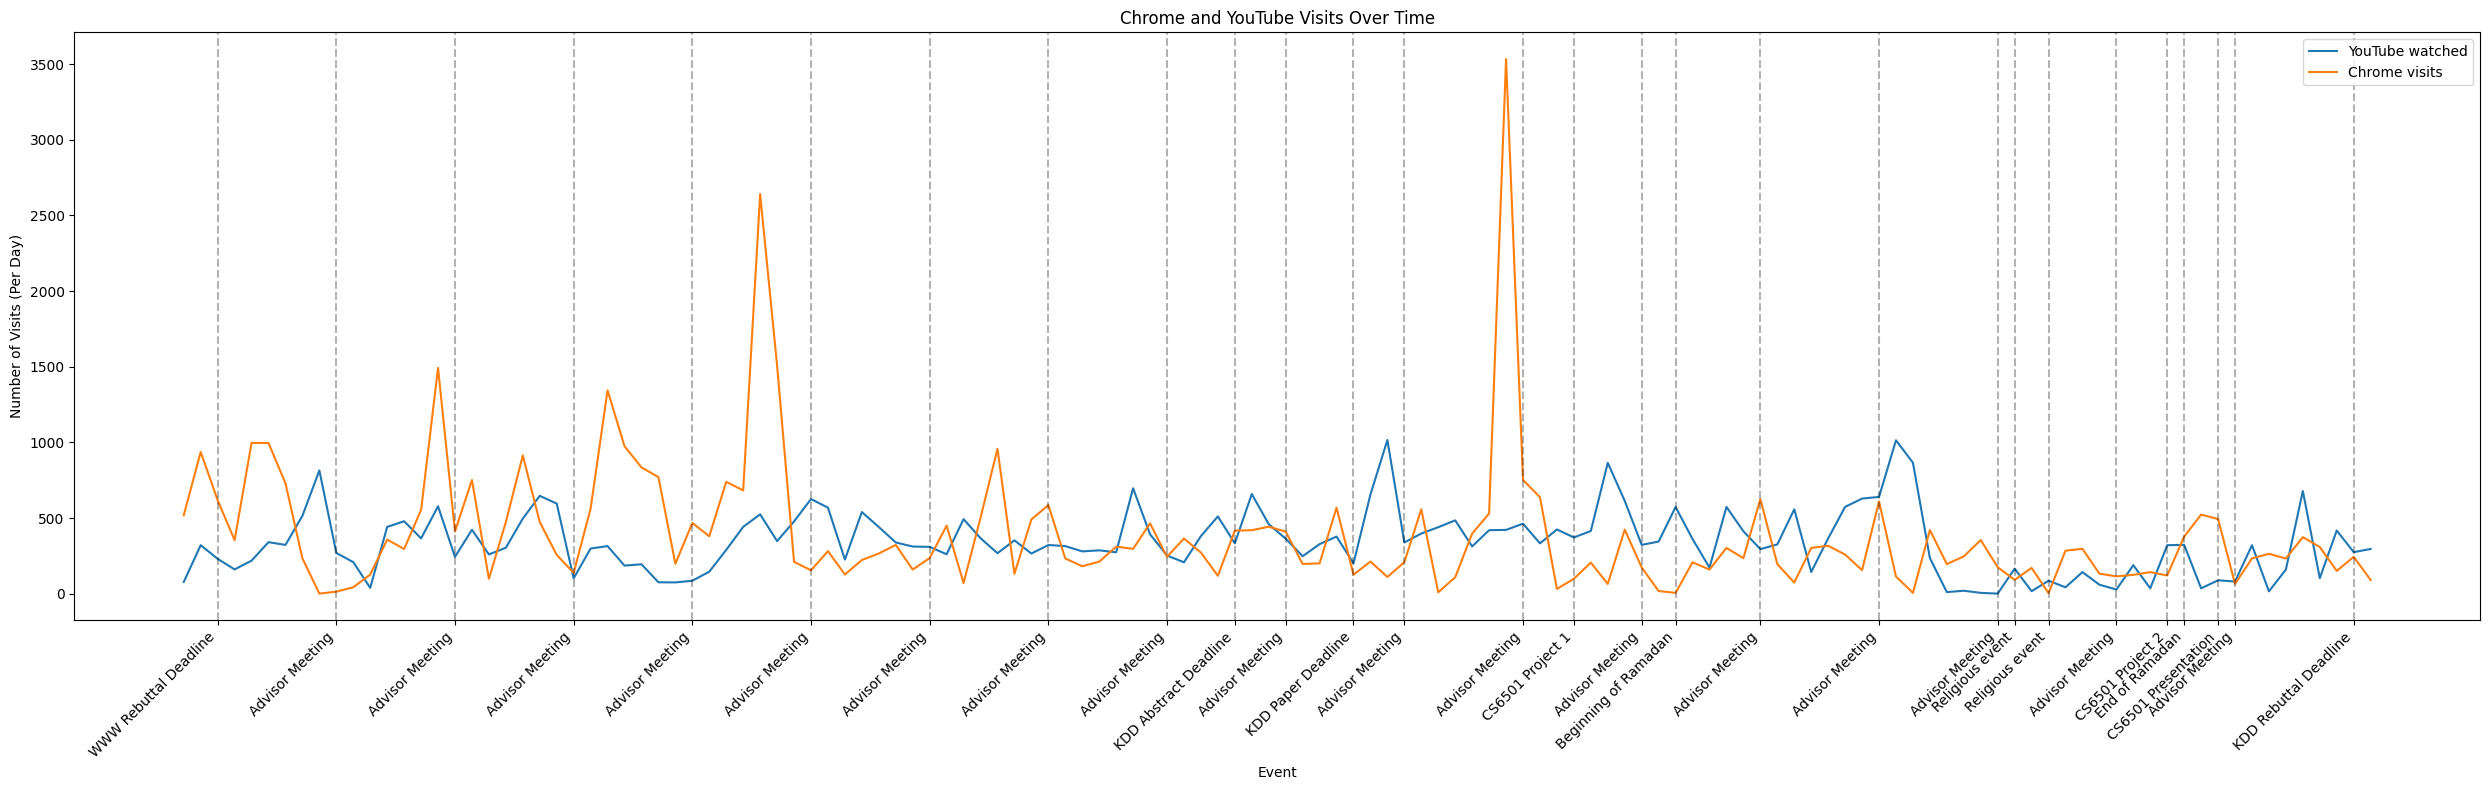

In [18]:
plt.figure(figsize=(25,8))
plt.plot(df.index, df['youtube_videos_watched'], label='YouTube watched')
plt.plot(df.index, df['chrome_visits'], label='Chrome visits')

# Add vertical lines for events
for ev in events.index:
    plt.axvline(ev, color='k', linestyle='--', alpha=0.3)

# Set x-ticks to event dates and titles
plt.xticks(events.index, events['event_title'], rotation=45, ha='right')

plt.legend()
plt.title('Chrome and YouTube Visits Over Time')
plt.xlabel('Event')
plt.ylabel('Number of Visits (Per Day)')
plt.tight_layout()

## Correlation Analysis: 

#### Correlation between YouTube/Chrome vs. Academic/Personal event

In [5]:
# 1) flag “one day before an academic event”
academic_dates = events.index[events['event_type']=='academic']
days_before   = academic_dates - pd.Timedelta(days=1)
df['before_academic_event'] = df.index.isin(days_before).astype(int)

# 2) original “on the day of” correlations
r_youtube, p_youtube = pointbiserialr(df['type_academic'], df['youtube_videos_watched'])
r_chrome,  p_chrome  = pointbiserialr(df['type_academic'], df['chrome_visits'])
print(f"Point-biserial corr (academic vs YouTube): r={r_youtube:.3f}, p={p_youtube:.3f}")
print(f"Point-biserial corr (academic vs Chrome):  r={r_chrome:.3f}, p={p_chrome:.3f}")

# 3) “one day before” correlations
r_youtube_before, p_youtube_before = pointbiserialr(
    df['before_academic_event'],
    df['youtube_videos_watched']
)
r_chrome_before, p_chrome_before = pointbiserialr(
    df['before_academic_event'],
    df['chrome_visits']
)
print(f"Point-biserial corr (1 day before vs YouTube): r={r_youtube_before:.3f}, p={p_youtube_before:.3f}")
print(f"Point-biserial corr (1 day before vs Chrome):  r={r_chrome_before:.3f}, p={p_chrome_before:.3f}")

Point-biserial corr (academic vs YouTube): r=-0.158, p=0.073
Point-biserial corr (academic vs Chrome):  r=-0.088, p=0.319
Point-biserial corr (1 day before vs YouTube): r=0.108, p=0.219
Point-biserial corr (1 day before vs Chrome):  r=0.095, p=0.284


In [6]:
# 1) flag “one day before a personal event”
personal_dates = events.index[events['event_type']=='personal']
days_before   = personal_dates - pd.Timedelta(days=1)
df['before_personal_event'] = df.index.isin(days_before).astype(int)

# 2) original “on the day of” correlations
r_youtube, p_youtube = pointbiserialr(df['type_personal'], df['youtube_videos_watched'])
r_chrome,  p_chrome  = pointbiserialr(df['type_personal'], df['chrome_visits'])
print(f"Point-biserial corr (personal vs YouTube): r={r_youtube:.3f}, p={p_youtube:.3f}")
print(f"Point-biserial corr (personal vs Chrome):  r={r_chrome:.3f}, p={p_chrome:.3f}")

# 3) “one day before” correlations
r_youtube_before, p_youtube_before = pointbiserialr(
    df['before_personal_event'],
    df['youtube_videos_watched']
)
r_chrome_before, p_chrome_before = pointbiserialr(
    df['before_personal_event'],
    df['chrome_visits']
)
print(f"Point-biserial corr (1 day before vs YouTube): r={r_youtube_before:.3f}, p={p_youtube_before:.3f}")
print(f"Point-biserial corr (1 day before vs Chrome):  r={r_chrome_before:.3f}, p={p_chrome_before:.3f}")

Point-biserial corr (personal vs YouTube): r=-0.048, p=0.591
Point-biserial corr (personal vs Chrome):  r=-0.110, p=0.213
Point-biserial corr (1 day before vs YouTube): r=-0.147, p=0.094
Point-biserial corr (1 day before vs Chrome):  r=-0.109, p=0.216


### Correlation between # of times a certain site type is visited and an academic/personal event.

In [7]:
# 1. Gather your site-type columns
site_type_cols = unique_types  # e.g. ['social', 'news', 'other', ...]

# 2. Compute r and p for each one
cor_results = []
for col in site_type_cols:
    r, p = pointbiserialr(df['type_academic'], df[col])
    cor_results.append({
        'site_type': col,
        'r_pb':        r,
        'p_value':    p
    })

# 3. Turn into a DataFrame for nicer display
cor_df = pd.DataFrame(cor_results).set_index('site_type')

In [8]:
cor_df

,r_pb,p_value
site_type,,
class_work,0.123297,0.162244
other,-0.115903,0.189129
research(dev),-0.052978,0.549421
research(explore),-0.074048,0.402438


In [9]:
# 1. Gather your site-type columns
site_type_cols = unique_types  # e.g. ['social', 'news', 'other', ...]

# 2. Compute r and p for each one
cor_results = []
for col in site_type_cols:
    r, p = pointbiserialr(df['type_personal'], df[col])
    cor_results.append({
        'site_type': col,
        'r_pb':        r,
        'p_value':    p
    })

# 3. Turn into a DataFrame for nicer display
cor_df = pd.DataFrame(cor_results).set_index('site_type')
cor_df

,r_pb,p_value
site_type,,
class_work,-0.104958,0.234661
other,-0.082566,0.350355
research(dev),-0.092393,0.295787
research(explore),-0.087060,0.324665


### Correlation between # of times a certain site type is visited and one day before an academic/personal event.

In [10]:
# 1) Identify the dates of academic events
academic_dates = events.loc[events['event_type'] == 'academic'].index

# 2) Compute the “day before” those dates
days_before_academic = academic_dates - pd.Timedelta(days=1)

# 3) Add a new column to df
df['before_academic_event'] = df.index.isin(days_before_academic).astype(int)

# 4) (Optionally) check how many “before” days you have
print(df['before_academic_event'].value_counts())

# 5) Compute point-biserial for the day-before flag vs each site‐type
site_type_cols = unique_types  # the list you built earlier
results = []
for col in site_type_cols:
    r, p = pointbiserialr(df['before_academic_event'], df[col])
    results.append({'site_type': col, 'r_pb': r, 'p_value': p})

before_corr_df = pd.DataFrame(results).set_index('site_type')
print(before_corr_df)

before_academic_event
0    106
1     24
Name: count, dtype: int64
                       r_pb   p_value
site_type                            
class_work         0.221527  0.011310
other              0.121297  0.169216
research(dev)      0.041728  0.637371
research(explore)  0.066105  0.454909


In [11]:
# 1) Identify the dates of personal events
personal_dates = events.loc[events['event_type'] == 'personal'].index

# 2) Compute the “day before” those dates
days_before_personal = personal_dates - pd.Timedelta(days=1)

# 3) Add a new column to df
df['before_personal_event'] = df.index.isin(days_before_personal).astype(int)

# 4) (Optionally) check how many “before” days you have
print(df['before_personal_event'].value_counts())

# 5) Compute point-biserial for the day-before flag vs each site‐type
site_type_cols = unique_types  # the list you built earlier
results = []
for col in site_type_cols:
    r, p = pointbiserialr(df['before_personal_event'], df[col])
    results.append({'site_type': col, 'r_pb': r, 'p_value': p})

before_corr_df = pd.DataFrame(results).set_index('site_type')
print(before_corr_df)

before_personal_event
0    126
1      4
Name: count, dtype: int64
                       r_pb   p_value
site_type                            
class_work        -0.054583  0.537374
other             -0.154625  0.078994
research(dev)     -0.086211  0.329420
research(explore) -0.074234  0.401253


### Spearman Correlation

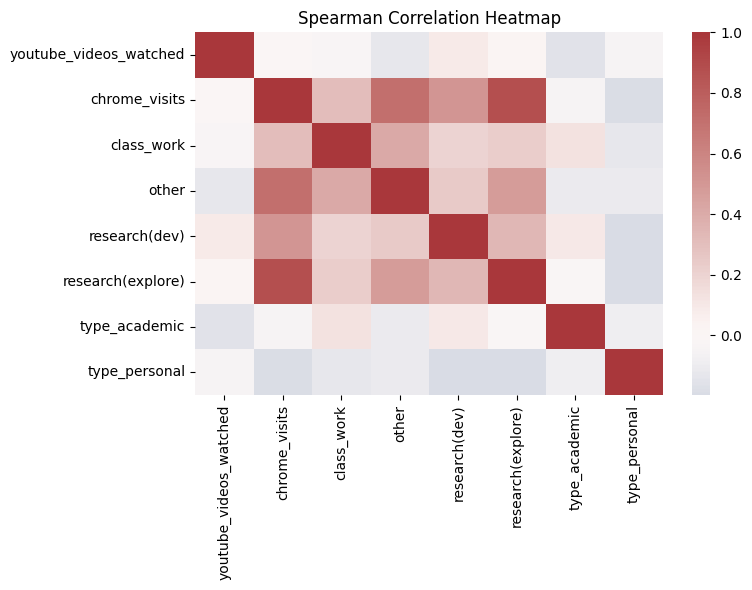

In [12]:
# Spearman’s rho correlation matrix
corr_cols = (
    ['youtube_videos_watched','chrome_visits']
    + unique_types
    + ['type_academic','type_personal']
)
corr_matrix = df[corr_cols].corr(method='spearman')

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, center=0, cmap='vlag')
plt.title("Spearman Correlation Heatmap")
plt.tight_layout()

### Cross Correlation Function

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def cross_corr_lags(x, y, maxlag):
    """
    Compute Pearson r(x_t, y_{t+lag}) for lag in [-maxlag..+maxlag].
    Returns (lags, r_values).
    """
    lags = np.arange(-maxlag, maxlag+1)
    r_vals = []
    for lag in lags:
        # shift y **backwards** by lag so that y.shift(-lag)[t] = y[t+lag]
        y_shifted = y.shift(-lag)
        # drop NaNs that arise from shifting
        valid = x.notna() & y_shifted.notna()
        r = x[valid].corr(y_shifted[valid])
        r_vals.append(r)
    return lags, np.array(r_vals)



#### Academic 

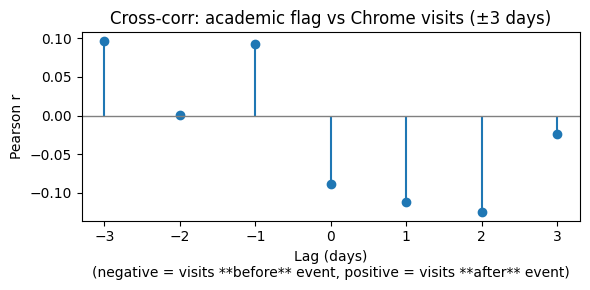

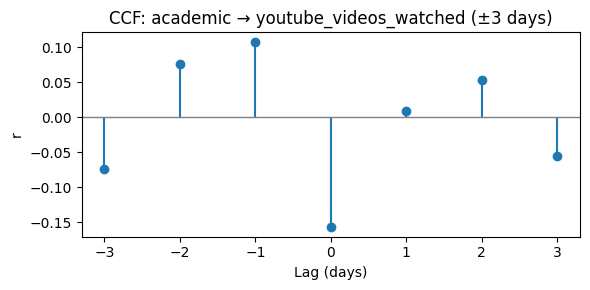

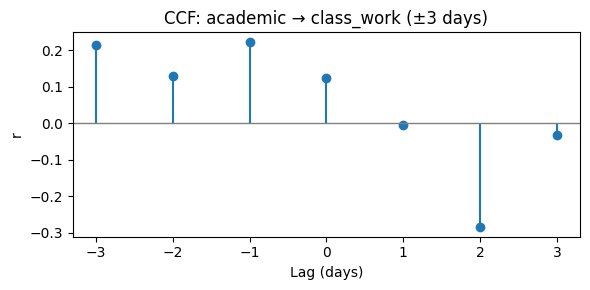

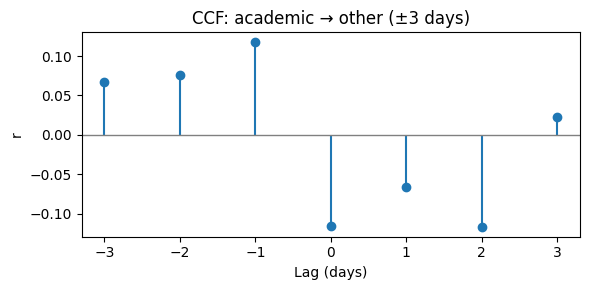

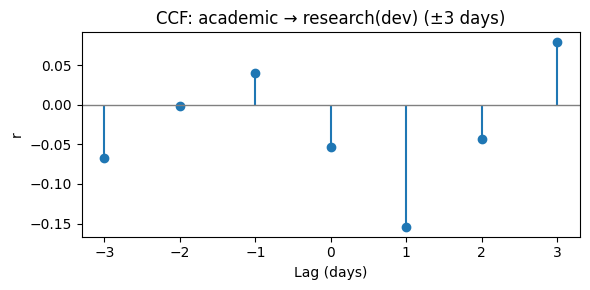

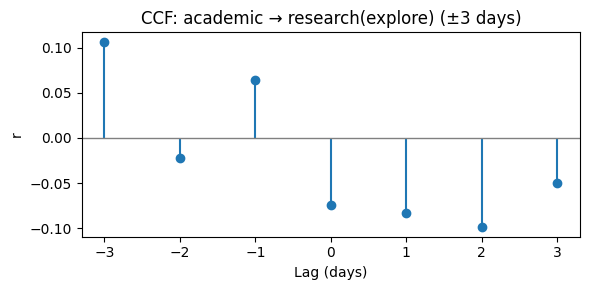

In [14]:
maxlag = 3
x = df['type_academic']
y = df['chrome_visits']

lags, r_vals = cross_corr_lags(x, y, maxlag)

plt.figure(figsize=(6,3))
plt.stem(lags, r_vals, basefmt=" ")
plt.axhline(0, color='gray', linewidth=1)
plt.xlabel('Lag (days)\n(negative = visits **before** event, positive = visits **after** event)')
plt.ylabel('Pearson r')
plt.title(f'Cross-corr: academic flag vs Chrome visits (±{maxlag} days)')
plt.tight_layout()

for col in ['youtube_videos_watched'] + unique_types:
    x = df['type_academic']
    y = df[col]
    lags, r_vals = cross_corr_lags(x, y, maxlag=maxlag)
    plt.figure(figsize=(6,3))
    plt.stem(lags, r_vals, basefmt=" ")
    plt.title(f'CCF: academic → {col} (±{maxlag} days)')
    plt.axhline(0, color='gray', linewidth=1)
    plt.xlabel('Lag (days)')
    plt.ylabel('r')
    plt.tight_layout()
    plt.show()

#### Personal

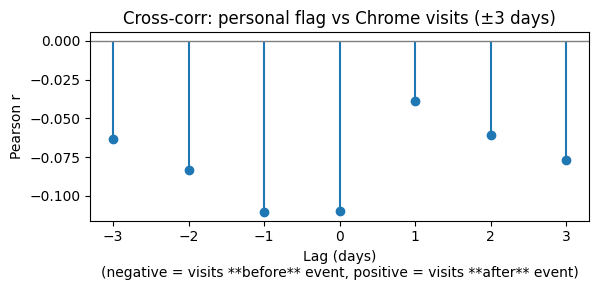

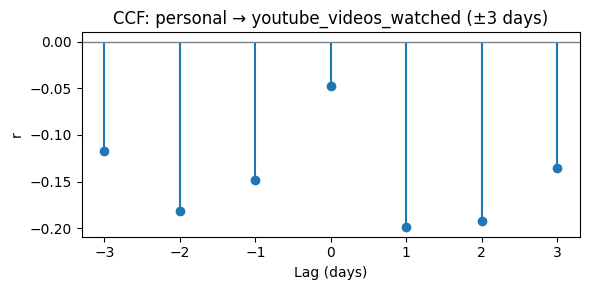

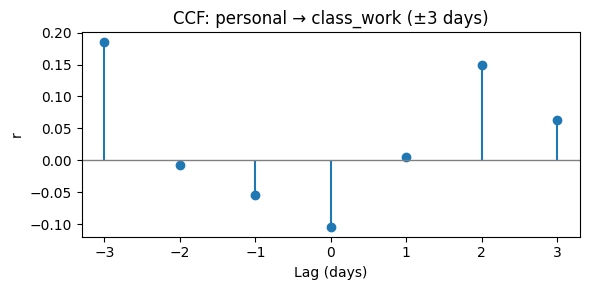

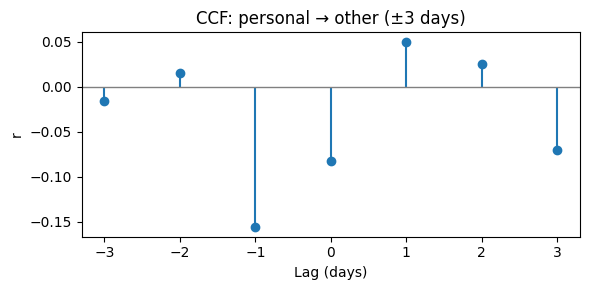

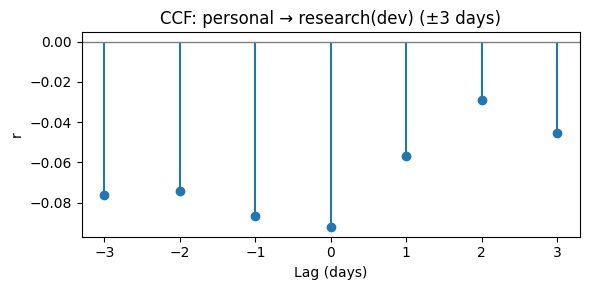

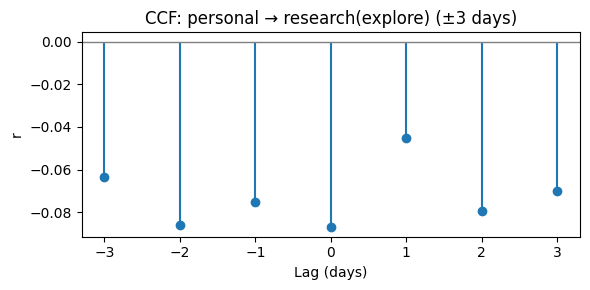

In [15]:
maxlag = 3
x = df['type_personal']
y = df['chrome_visits']

lags, r_vals = cross_corr_lags(x, y, maxlag)

plt.figure(figsize=(6,3))
plt.stem(lags, r_vals, basefmt=" ")
plt.axhline(0, color='gray', linewidth=1)
plt.xlabel('Lag (days)\n(negative = visits **before** event, positive = visits **after** event)')
plt.ylabel('Pearson r')
plt.title(f'Cross-corr: personal flag vs Chrome visits (±{maxlag} days)')
plt.tight_layout()

for col in ['youtube_videos_watched'] + unique_types:
    x = df['type_personal']
    y = df[col]
    lags, r_vals = cross_corr_lags(x, y, maxlag=maxlag)
    plt.figure(figsize=(6,3))
    plt.stem(lags, r_vals, basefmt=" ")
    plt.title(f'CCF: personal → {col} (±{maxlag} days)')
    plt.axhline(0, color='gray', linewidth=1)
    plt.xlabel('Lag (days)')
    plt.ylabel('r')
    plt.tight_layout()
    plt.show()

## Regression

In [16]:
# --- 5. Regression / Predictive Modeling ---
# Logistic regression: predict academic day from activity
X = df[['youtube_videos_watched','chrome_visits']]
# X = df[['youtube_videos_watched','chrome_visits'] + top10]
y = df['type_academic']
logreg = LogisticRegression(max_iter=1000).fit(X, y)
print("Logistic Regression coefficients (academic pred):\n", 
      pd.Series(logreg.coef_[0], index=X.columns).sort_values())
# Logistic regression: predict academic day from activity
X = df[['youtube_videos_watched','chrome_visits']]
# X = df[['youtube_videos_watched','chrome_visits'] + top10]
y = df['type_personal']
logreg = LogisticRegression(max_iter=1000).fit(X, y)
print("Logistic Regression coefficients (personal pred):\n", 
      pd.Series(logreg.coef_[0], index=X.columns).sort_values())

# Linear regression: effect of academic flag on YouTube views
linreg = LinearRegression().fit(df[['type_academic']], df['youtube_videos_watched'])
print(f"Linear effect of academic day on YouTube views: β = {linreg.coef_[0]:.3f}")

linreg = LinearRegression().fit(df[['type_personal']], df['youtube_videos_watched'])
print(f"Linear effect of personal day on YouTube views: β = {linreg.coef_[0]:.3f}")

linreg = LinearRegression().fit(df[['type_academic']], df['chrome_visits'])
print(f"Linear effect of academic day on Chrome visits: β = {linreg.coef_[0]:.3f}")

linreg = LinearRegression().fit(df[['type_personal']], df['chrome_visits'])
print(f"Linear effect of personal day on Chrome visits: β = {linreg.coef_[0]:.3f}")


plt.show()

Logistic Regression coefficients (academic pred):
 youtube_videos_watched   -0.002112
chrome_visits            -0.000783
dtype: float64
Logistic Regression coefficients (personal pred):
 chrome_visits            -0.009461
youtube_videos_watched   -0.001876
dtype: float64
Linear effect of academic day on YouTube views: β = -84.084
Linear effect of personal day on YouTube views: β = -57.024
Linear effect of academic day on Chrome visits: β = -101.574
Linear effect of personal day on Chrome visits: β = -284.492
